# **Sentiment Analysis** of the **Restaurant Reviews** from **YELP** Dataset

## **Preprocessing**:

#### Set the path to the **reviews** dataset

In [1]:
path = 'gs://demo2222/yelp_academic_dataset_review.json'

#### Import the required libraries

In [2]:
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import re
import spacy
sp = spacy.load('en_core_web_sm')
import tensorflow as tf
from langdetect import detect
import sys
import os
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 


#### Read the dataset

In [3]:
df = pd.read_json(path, lines=True)

#### Get the memory usage and the shape of the dataset

In [4]:
print(df.memory_usage(deep=True).sum())
print(df.shape)

8135632709
(8635403, 9)


#### As this dataset it's a **very heavy** one, let's use only the first 10,000 rows and **reduce** the **memory usage** 

In [5]:
df = pd.read_json(path, lines=True, nrows=10000)
print(df.memory_usage(deep=True).sum())
print(df.shape)

9174108
(10000, 9)


In [6]:
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,lWC-xP3rd6obsecCYsGZRg,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,4,3,1,1,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02
1,8bFej1QE5LXp4O05qjGqXA,YoVfDbnISlW0f7abNQACIg,RA4V8pr014UyUbDvI-LW2A,4,1,0,0,This store is pretty good. Not as great as Wal...,2015-07-03 20:38:25
2,NDhkzczKjLshODbqDoNLSg,eC5evKn1TWDyHCyQAwguUw,_sS2LBIGNT5NQb6PD1Vtjw,5,0,0,0,I called WVM on the recommendation of a couple...,2013-05-28 20:38:06
3,T5fAqjjFooT4V0OeZyuk1w,SFQ1jcnGguO0LYWnbbftAA,0AzLzHfOJgL7ROwhdww2ew,2,1,1,1,I've stayed at many Marriott and Renaissance M...,2010-01-08 02:29:15
4,sjm_uUcQVxab_EeLCqsYLg,0kA0PAJ8QFMeveQWHFqz2A,8zehGz9jnxPqXtOc7KaJxA,4,0,0,0,The food is always great here. The service fro...,2011-07-28 18:05:01


#### **Drop the columns** that we **won't be needing**

In [7]:
cols_to_drop = ['review_id', 'user_id', 'useful', 'funny', 'cool', 'date'] 
df.drop(cols_to_drop, axis=1, inplace=True)

In [8]:
df.head()

,business_id,stars,text
0,buF9druCkbuXLX526sGELQ,4,Apparently Prides Osteria had a rough summer a...
1,RA4V8pr014UyUbDvI-LW2A,4,This store is pretty good. Not as great as Wal...
2,_sS2LBIGNT5NQb6PD1Vtjw,5,I called WVM on the recommendation of a couple...
3,0AzLzHfOJgL7ROwhdww2ew,2,I've stayed at many Marriott and Renaissance M...
4,8zehGz9jnxPqXtOc7KaJxA,4,The food is always great here. The service fro...


#### Set the path to the **business** dataset

In [9]:
path1 = 'gs://demo2222/yelp_academic_dataset_business.json'

#### Read the dataset

In [10]:
df1 = pd.read_json(path1, lines=True)

In [11]:
df1.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,1,"{'RestaurantsTableService': 'True', 'WiFi': 'u...","Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'..."
1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ..."
2,bvN78flM8NLprQ1a1y5dRg,The Reclaimory,4720 Hawthorne Ave,Portland,OR,97214,45.511907,-122.613693,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Antiques, Fashion, Used, Vintage & Consignment...","{'Thursday': '11:0-18:0', 'Friday': '11:0-18:0..."
3,oaepsyvc0J17qwi8cfrOWg,Great Clips,2566 Enterprise Rd,Orange City,FL,32763,28.914482,-81.295979,3.0,8,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Beauty & Spas, Hair Salons",None
4,PE9uqAjdw0E4-8mjGl3wVA,Crossfit Terminus,1046 Memorial Dr SE,Atlanta,GA,30316,33.747027,-84.353424,4.0,14,1,"{'GoodForKids': 'False', 'BusinessParking': '{...","Gyms, Active Life, Interval Training Gyms, Fit...","{'Monday': '16:0-19:0', 'Tuesday': '16:0-19:0'..."


#### We **only** want to analyze the **restaurant** category from the **business** dataset

In [12]:
df1 = df1[df1['categories'].notnull()]
df_rest = df1[df1['categories'].str.contains('Restaurant')]

In [13]:
df_rest = df_rest[['business_id', 'categories']]

In [14]:
df_rest.head()

,business_id,categories
0,6iYb2HFDywm3zjuRg0shjw,"Gastropubs, Food, Beer Gardens, Restaurants, B..."
1,tCbdrRPZA0oiIYSmHG3J0w,"Salad, Soup, Sandwiches, Delis, Restaurants, C..."
5,D4JtQNTI4X3KcbzacDJsMw,"Restaurants, Thai"
7,jFYIsSb7r1QeESVUnXPHBw,"Breakfast & Brunch, Restaurants"
12,HPA_qyMEddpAEtFof02ixg,"Food, Pizza, Restaurants"


#### We want to **merge** the two datasets to analyse the **restaurant reviews**. "business_id" is the **common** columm of the two datasets

In [15]:
df_merged = df.merge(df_rest, how='inner', on='business_id')

In [16]:
df_merged.head()

,business_id,stars,text,categories
0,buF9druCkbuXLX526sGELQ,4,Apparently Prides Osteria had a rough summer a...,"Restaurants, Wine Bars, Nightlife, Farmers Mar..."
1,buF9druCkbuXLX526sGELQ,2,I was really disappointed to say the least. I ...,"Restaurants, Wine Bars, Nightlife, Farmers Mar..."
2,buF9druCkbuXLX526sGELQ,5,This is as close to dining in Italy as you'll ...,"Restaurants, Wine Bars, Nightlife, Farmers Mar..."
3,buF9druCkbuXLX526sGELQ,5,Great food and service! Again. 4 out of the la...,"Restaurants, Wine Bars, Nightlife, Farmers Mar..."
4,0AzLzHfOJgL7ROwhdww2ew,2,I've stayed at many Marriott and Renaissance M...,"Hotels, Hotels & Travel, Restaurants, Event Pl..."


#### **Rename** the **text column** and **remove** the **"business_id"** column because it isn't necessary anymore

In [17]:
df_merged.rename(columns={'text':'restaurant_reviews'}, inplace=True)
df_merged.drop('business_id', axis=1, inplace=True)

#### We will **only** analyse the reviews written in **English**

In [18]:
df_merged['detect'] = df_merged['restaurant_reviews'].apply(detect)
df_merged = df_merged[df_merged['detect'] == 'en'].reset_index(drop=True)

In [19]:
# Check if there is NaN values
df_merged.isnull().values.any()

False

In [20]:
df_merged.shape

(6988, 4)

#### Return the dataframe with **duplicate** rows **removed**

In [21]:
df_final = df_merged.drop_duplicates()

#### If we want to **save** some **ram memory**:

In [22]:
del df_merged, df_rest

In [23]:
df_final.shape

(6988, 4)

#### As **many** of the **3 stars reviews**, most likely, have both **good and bad aspects/feelings**, we will **remove** those reviews so they **won't harm** our sentiment analysis

In [24]:
df_final = df_final[(df_final["stars"]!=3)]
df_final.head(20)

,stars,restaurant_reviews,categories,detect
0,4,Apparently Prides Osteria had a rough summer a...,"Restaurants, Wine Bars, Nightlife, Farmers Mar...",en
1,2,I was really disappointed to say the least. I ...,"Restaurants, Wine Bars, Nightlife, Farmers Mar...",en
2,5,This is as close to dining in Italy as you'll ...,"Restaurants, Wine Bars, Nightlife, Farmers Mar...",en
3,5,Great food and service! Again. 4 out of the la...,"Restaurants, Wine Bars, Nightlife, Farmers Mar...",en
4,2,I've stayed at many Marriott and Renaissance M...,"Hotels, Hotels & Travel, Restaurants, Event Pl...",en
5,4,I was a there for a professional conference. s...,"Hotels, Hotels & Travel, Restaurants, Event Pl...",en
6,4,I stayed for five nights this past April with ...,"Hotels, Hotels & Travel, Restaurants, Event Pl...",en
7,4,I stayed here recently for a conference I was ...,"Hotels, Hotels & Travel, Restaurants, Event Pl...",en
8,4,The food is always great here. The service fro...,"Restaurants, French",en
9,2,Brasserie zero zero... we were hoping for a te...,"Restaurants, French",en


#### Label reviews as positive - **1** - or negative - **0** - and after that **remove** the **"stars" column**, it is not needed anymore

In [25]:
df_final.loc[df_final['stars'] < 3, 'sentiment'] = 0 
df_final.loc[df_final['stars'] > 3, 'sentiment'] = 1
df_final.drop('stars', axis=1, inplace=True)
df_final.head(20)

,restaurant_reviews,categories,detect,sentiment
0,Apparently Prides Osteria had a rough summer a...,"Restaurants, Wine Bars, Nightlife, Farmers Mar...",en,1.0
1,I was really disappointed to say the least. I ...,"Restaurants, Wine Bars, Nightlife, Farmers Mar...",en,0.0
2,This is as close to dining in Italy as you'll ...,"Restaurants, Wine Bars, Nightlife, Farmers Mar...",en,1.0
3,Great food and service! Again. 4 out of the la...,"Restaurants, Wine Bars, Nightlife, Farmers Mar...",en,1.0
4,I've stayed at many Marriott and Renaissance M...,"Hotels, Hotels & Travel, Restaurants, Event Pl...",en,0.0
5,I was a there for a professional conference. s...,"Hotels, Hotels & Travel, Restaurants, Event Pl...",en,1.0
6,I stayed for five nights this past April with ...,"Hotels, Hotels & Travel, Restaurants, Event Pl...",en,1.0
7,I stayed here recently for a conference I was ...,"Hotels, Hotels & Travel, Restaurants, Event Pl...",en,1.0
8,The food is always great here. The service fro...,"Restaurants, French",en,1.0
9,Brasserie zero zero... we were hoping for a te...,"Restaurants, French",en,0.0


In [26]:
df_final.dtypes

restaurant_reviews     object
categories             object
detect                 object
sentiment             float64
dtype: object

#### Let's see if the dataset is **balanced or not**: **it isn't...**

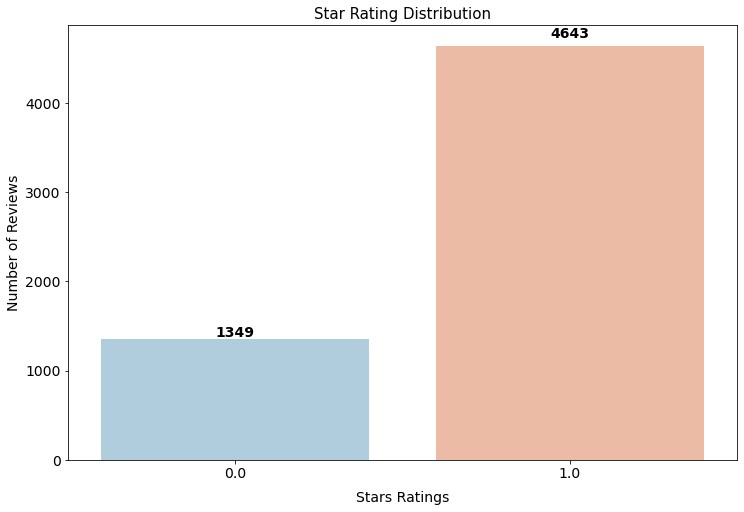

In [27]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

plt.figure(figsize=(12,8))
grouped = df_final.sentiment.value_counts().sort_index()
sns.barplot(grouped.index, grouped.values, palette=sns.color_palette("RdBu_r", len(grouped)))
plt.xlabel('Stars Ratings', labelpad=10, fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.title('Star Rating Distribution', fontsize=15)
plt.tick_params(labelsize=14)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)

#### As the dataset is **imbalanced** we **upsample** the **minority class** (negative sentiment - 0)

In [28]:
from sklearn.utils import resample
# upsample minority class
#create two different dataframes: one regarding the majority and the other the minority class 
df_majority = df_final[(df_final['sentiment']==1)] 
df_minority = df_final[(df_final['sentiment']==0)] 


df_minority_upsampled = resample(df_minority, 
                                 replace=True,   
                                 n_samples= 4643, # to match majority class
                                 random_state=42)  
# Combine majority class with upsampled minority class
df_final = pd.concat([df_minority_upsampled, df_majority])

In [29]:
df_final.sentiment.value_counts()


0.0    4643
1.0    4643
Name: sentiment, dtype: int64

In [30]:
df_final = df_final.reset_index(drop=True)
df_final.head()

,restaurant_reviews,categories,detect,sentiment
0,"There were maybe 8 tables in the restaurant, ...","Bars, Restaurants, Chicken Wings, Sports Bars,...",en,0.0
1,The food was good but Worst service I ever had...,"Restaurants, American (New)",en,0.0
2,Be aware the April server charge extra tip to ...,"American (Traditional), Restaurants, Bars, Tex...",en,0.0
3,This place has really gone down hill on servic...,"Restaurants, Cafes, Breakfast & Brunch",en,0.0
4,"Placed order online for delivery, to be delive...","Sandwiches, Wraps, Chicken Wings, Restaurants",en,0.0


#### **Stopwords** with **spaCy**. As **'no'** and **'not'** are **important** words to describe an opinion about a restaurant (e.g. not cheap, not a good service, no napkins available, etc.), we should, at least, **remove** those two words from the **stopwords**.

In [31]:
sp = spacy.load('en_core_web_sm')
stopwords = sp.Defaults.stop_words

exclude_stopwords = ['no','not']
for word in exclude_stopwords:
    stopwords.remove(word)

#### **UDF** to use **spaCy** to **lemmatize** and **filter** the **stopwords**, then **remove non-letters** and convert the restaurant reviews to **lower case**  .

In [32]:

def spacy_process(text):
    doc = sp(text)
    
# Lemmatization with Spacy

    lemma_list = []
    for token in doc:
        lemma_list.append(token.lemma_)
            
    #Filter the stopwords, remove non-letters and lower case 
    
    filtered_sentence =[] 
    for word in lemma_list:
        lexeme = sp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word)
    lower_words = []
    for word in filtered_sentence:
        text_letters_only = re.sub("[^a-zA-Z]", " ", word) 
        text_words_lower = text_letters_only.lower()  
        lower_words.append(text_words_lower)
    text_final = " ".join(lower_words)
    return  " ".join(text_final.split())

#### An example

In [33]:
spacy_process(df_final['restaurant_reviews'][0])

'maybe table restaurant waitress busy talk buddy assist food horrible daughter honey bbq wing sauce taste spoil thai curry sauce sour sweet menu synopsis state yuck'

#### **Apply** the above **UDF** to the **entire** 'restaurant_reviews' column, **creating** a **new column** named **cleaned_reviews'**

In [34]:
df_final['cleaned_reviews'] = df_final['restaurant_reviews'].apply(spacy_process)

In [35]:
df_final.isnull().values.any()

False

In [36]:
df_final.head()

,restaurant_reviews,categories,detect,sentiment,cleaned_reviews
0,"There were maybe 8 tables in the restaurant, ...","Bars, Restaurants, Chicken Wings, Sports Bars,...",en,0.0,maybe table restaurant waitress busy talk budd...
1,The food was good but Worst service I ever had...,"Restaurants, American (New)",en,0.0,food good bad service bad mean bad menu silver...
2,Be aware the April server charge extra tip to ...,"American (Traditional), Restaurants, Bars, Tex...",en,0.0,aware april server charge extra tip pay tip
3,This place has really gone down hill on servic...,"Restaurants, Cafes, Breakfast & Brunch",en,0.0,place hill service waitress food prep delivery...
4,"Placed order online for delivery, to be delive...","Sandwiches, Wraps, Chicken Wings, Restaurants",en,0.0,place order online delivery deliver work break...


#### Let's save into the bucket the dataset with **only** the columns of our interest

In [41]:
df_final = df_final[['cleaned_reviews','sentiment']]

In [42]:
df_final.to_csv('gs://demo2222/df_final.csv', index=False)